In [1]:
import os
import pickle
import sys

import ase
import ase.data
import ase.io
import ase.visualize
import jax
import jax.numpy as jnp
import jraph
import ml_collections
import tqdm
import yaml

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

sys.path.append("..")


In [2]:
import datatypes
import input_pipeline
import qm9
from models import ATOMIC_NUMBERS, RADII, create_model

In [3]:
# path = "/home/ameyad/spherical-harmonic-net/workdirs/v3/mace/interactions=3/l=2/channels=32"
path = "/home/ameyad/spherical-harmonic-net/workdirs/v3/e3schnet/interactions=4/l=3/channels=32"
# path = "/home/ameyad/spherical-harmonic-net/workdirs/v3/mace/interactions=4/l=3/channels=32"
# path = "/home/ameyad/spherical-harmonic-net/workdirs/v3/mace/interactions=4/l=5/channels=32"
# path = "/home/ameyad/spherical-harmonic-net/workdirs/v4/mace/interactions=6/l=4/channels=32"
# path = "/home/ameyad/spherical-harmonic-net/workdirs/v4/mace/interactions=2/l=4/channels=32"
# path = "/home/ameyad/spherical-harmonic-net/workdirs/v4/mace/interactions=5/l=5/channels=32"
# path = "/home/ameyad/spherical-harmonic-net/workdirs/extras/num_layers/mace/interactions=4/l=5/channels=32/num_layers=4"
path = "/home/ameyad/spherical-harmonic-net/workdirs/v4/mace/interactions=4/l=4/channels=32"

with open(path + "/checkpoints/params.pkl", "rb") as f:
    params = pickle.load(f)
with open(path + "/config.yml", "rt") as config_file:
    config = yaml.unsafe_load(config_file)

assert config is not None
config = ml_collections.ConfigDict(config)


In [4]:
config.target_position_predictor.res_alpha = 359
config.target_position_predictor.res_beta = 180

config.target_position_predictor.res_alpha = 181
config.target_position_predictor.res_beta = 90


In [5]:
model = create_model(config, run_in_evaluation_mode=True, beamlined=True)
apply_fn = jax.jit(model.apply)


def apply(frag, seed, beta):
    frags = jraph.pad_with_graphs(frag, 32, 1024, 2)
    preds = apply_fn(params, seed, frags, beta)
    pred = jraph.unpad_with_graphs(preds)
    return pred


In [6]:
def append_pred_to_ase_atoms(
    molecule: ase.Atoms, pred: datatypes.Predictions
) -> ase.Atoms:
    focus = pred.globals.focus_indices.squeeze(0)
    pos_focus = molecule.positions[focus]
    pos_rel = pred.globals.position_vectors.squeeze(0)

    new_specie = jnp.array(
        ATOMIC_NUMBERS[pred.globals.target_species.squeeze(0).item()]
    )
    new_position = pos_focus + pos_rel

    return ase.Atoms(
        positions=jnp.concatenate([molecule.positions, new_position[None, :]], axis=0),
        numbers=jnp.concatenate([molecule.numbers, new_specie[None]], axis=0),
    )


In [7]:
name = path.split("/")[-5:]
name = "_".join(name)

beta = 1

name = f"{name}_beta={beta}"

print(name)

v4_mace_interactions=4_l=4_channels=32_beta=1


In [8]:
molecules = []

if not os.path.exists(f"gen/{name}"):
    os.mkdir(f"gen/{name}")

for seed in range(64):
    molecule = ase.Atoms(
        positions=jnp.array([[0, 0, 0.0]]),
        numbers=jnp.array([6]),
    )

    rng = jax.random.PRNGKey(seed)
    for step in range(31):
        k, rng = jax.random.split(rng)
        frag = input_pipeline.ase_atoms_to_jraph_graph(
            molecule, ATOMIC_NUMBERS, config.nn_cutoff
        )
        pred = apply(frag, k, beta)

        if any(jnp.isnan(x).any() for x in jax.tree_util.tree_leaves(pred)):
            print("NaNs detected")
            break

        stop_prob = pred.globals.stop_probs.squeeze(0).item()
        if stop_prob > 0.01:
            print(f"Seed {seed} Step {step} stop prob {stop_prob:.2f}")

        stop = pred.globals.stop.squeeze(0).item()
        if stop:
            molecules.append(molecule)

            ase.io.write(f"gen/{name}/molecule_{seed}.xyz", molecule)

            print(f"Generated molecule {seed} of {len(molecule)} atoms")
            break

        molecule = append_pred_to_ase_atoms(molecule, pred)

NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
Seed 9 Step 3 stop prob 1.00
Generated molecule 9 of 4 atoms
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
Seed 16 Step 3 stop prob 1.00
Generated molecule 16 of 4 atoms
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
Seed 22 Step 3 stop prob 1.00
Generated molecule 22 of 4 atoms
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
NaNs detected
N

In [9]:
jax.tree_util.tree_map(lambda x: jnp.isnan(x).any(), pred)

GraphsTuple(nodes=NodePredictions(embeddings=128x0e+128x1o+128x2e+128x3o+128x4e True, focus_logits=Array(False, dtype=bool), focus_probs=Array(True, dtype=bool)), edges=None, receivers=Array(False, dtype=bool), senders=Array(False, dtype=bool), globals=GlobalPredictions(stop_probs=Array(True, dtype=bool), stop=Array(False, dtype=bool), focus_indices=Array(False, dtype=bool), target_species_logits=Array(False, dtype=bool), target_species_probs=None, target_species=Array(False, dtype=bool), position_coeffs=None, position_logits=SphericalSignal(True), position_probs=None, position_vectors=Array(False, dtype=bool)), n_node=Array(False, dtype=bool), n_edge=Array(False, dtype=bool))

In [10]:
import matplotlib.pyplot as plt


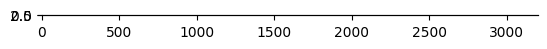

In [11]:
x = pred.nodes.embeddings

plt.imshow(x.array)


(0.0, 10000.0)

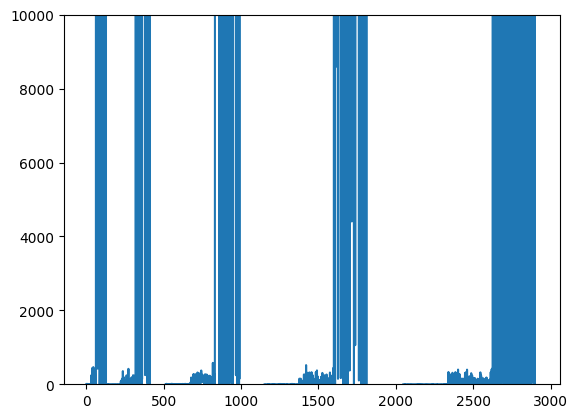

In [12]:
plt.plot(jnp.max(x.array, axis=0))
plt.ylim(0.0, 10000)


In [13]:
x.irreps.dim


3200